In [1]:
import numpy as np
import pandas as pd
import pingouin as pg
import nibabel as nb
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os
from mvpa.loading import load_betas
from utils import Options
from nilearn.image import new_img_like
from nilearn.plotting import plot_roi, plot_stat_map

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

In [2]:
def mask_functional_map(func, anat):
    """
    Simple helper function to mask a
    functional map using
    an anatomical one.
    """
    
    funcdata = func.get_fdata()
    anatdata = anat.get_fdata()
    
    masked = new_img_like(func, funcdata * anatdata)
    
    return masked


def get_roi_avg(func, anat):
    
    funcdata = func.get_fdata()
    anatdata = anat.get_fdata()
    
    masked = funcdata[anatdata.astype(bool)]
    
    return np.nanmean(masked)

def get_avg_AnotB(func, anat_A, anat_B):
    
    funcdata = func.get_fdata()
    anatAdata = anat_A.get_fdata()
    anatBdata = anat_B.get_fdata()
    
    masked = funcdata[(anatAdata.astype(bool))&~(anatBdata.astype(bool))]
    
    return masked
    

In [3]:
# General settings
subjlist = [f'sub-{i:03d}' for i in range(1, 36) if i != 6]
to_exclude = [f'sub-{i:03d}' for i in [1, 6, 17, 18]]
subjlist = [s for s in subjlist if s not in to_exclude]
roidir = '../../bids/derivatives/spm-preproc/derivatives/roi-masks/'
corrdir = '../../FIR_correlations/test_m29/ba-17-18_contr-objscrvsbas_top-500_nothresh/'
LOC_template = '{:s}_LO_contr-objvscr_top-500.nii'
BA19_template = '{:s}_ba-19_L_contr-objscrvsbas_top-100_nothresh.nii'
BA1937_template = '{:s}_ba-19-37_L_contr-objscrvsbas_top-100_nothresh.nii'
corr_template = '{:s}_allruns_{:s}.nii'
MT_mask = nb.load('../../anat_roi_masks/glasser-v5.nii')
MST_mask = nb.load('../../anat_roi_masks/glasser-MST.nii')
#BA19_mask = nb.load('../../anat_roi_masks/ba-19.nii')
#BA1937_mask = nb.load('../../anat_roi_masks/ba-19-37.nii')

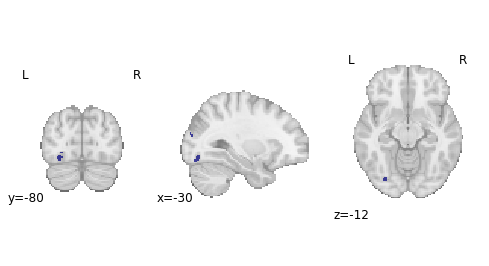

In [4]:
s = 'sub-001'
_ = plot_roi(os.path.join(roidir, s, BA1937_template.format(s)), draw_cross=False)

In [5]:
# Get LOC, MT and MST average 
# for each subject
df = []
for s in subjlist:
    thisLOCmask = nb.load(os.path.join(roidir, s, LOC_template.format(s)))
    BA19_mask = nb.load(os.path.join(roidir, s, BA19_template.format(s)))
    BA1937_mask = nb.load(os.path.join(roidir, s, BA1937_template.format(s)))
    for e in ['exp', 'unexp']:
        thisrow = {'subject': s, 'expected': e}
        thiscorrmap = nb.load(os.path.join(corrdir, corr_template.format(s, e)))
        LOCmean = get_roi_avg(thiscorrmap, thisLOCmask)
        MTmean = get_roi_avg(thiscorrmap, MT_mask)
        MSTmean = get_roi_avg(thiscorrmap, MST_mask)
        BA19mean = get_roi_avg(thiscorrmap, BA19_mask)
        BA1937mean = get_roi_avg(thiscorrmap, BA1937_mask)
        df.append(dict(thisrow, **{'roi': 'LOC', 'mean_corr': LOCmean}))
        df.append(dict(thisrow, **{'roi': 'MT', 'mean_corr': MTmean}))
        df.append(dict(thisrow, **{'roi': 'MST', 'mean_corr': MSTmean}))
        df.append(dict(thisrow, **{'roi': 'BA-19', 'mean_corr': BA19mean}))
        df.append(dict(thisrow, **{'roi': 'BA-19-37', 'mean_corr': BA1937mean}))
        
df = pd.DataFrame(df)

In [6]:
df

,subject,expected,roi,mean_corr
0,sub-002,exp,LOC,0.543417
1,sub-002,exp,MT,0.542174
2,sub-002,exp,MST,0.621146
3,sub-002,exp,BA-19,0.560931
4,sub-002,exp,BA-19-37,0.572162
...,...,...,...,...
305,sub-035,unexp,LOC,0.531790
306,sub-035,unexp,MT,0.519860
307,sub-035,unexp,MST,0.605048
308,sub-035,unexp,BA-19,0.589950


In [7]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='BA-19-37')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='BA-19-37')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.415871,30,two-sided,0.021995,"[0.03, 0.31]",0.589837,2.302,0.888258


In [8]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='BA-19')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='BA-19')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.415868,30,two-sided,0.021995,"[0.03, 0.3]",0.589436,2.302,0.887847


In [9]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='LOC')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='LOC')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.153416,30,two-sided,0.039447,"[0.01, 0.24]",0.461064,1.429,0.69996


In [10]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='MT')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='MT')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.281889,30,two-sided,0.00262,"[0.06, 0.27]",0.604152,14.099,0.902225


In [11]:
pg.ttest(df[(df['expected']=='exp')&(df['roi']=='MST')]['mean_corr'],
         df[(df['expected']=='unexp')&(df['roi']=='MST')]['mean_corr'],
         paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.615078,30,two-sided,0.116764,"[-0.02, 0.21]",0.34874,0.614,0.46797


In [12]:
aov = pg.rm_anova(data=df, dv='mean_corr', subject='subject',
                  within=['roi', 'expected'])
pg.print_table(aov)


ANOVA SUMMARY

Source             SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
--------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
roi             0.212        4      120  0.053  2.276    0.065        0.120  0.071  0.432
expected        1.592        1       30  1.592  6.220    0.018        0.018  0.172  1.000
roi * expected  0.070        4      120  0.018  2.113    0.083        0.112  0.066  0.670



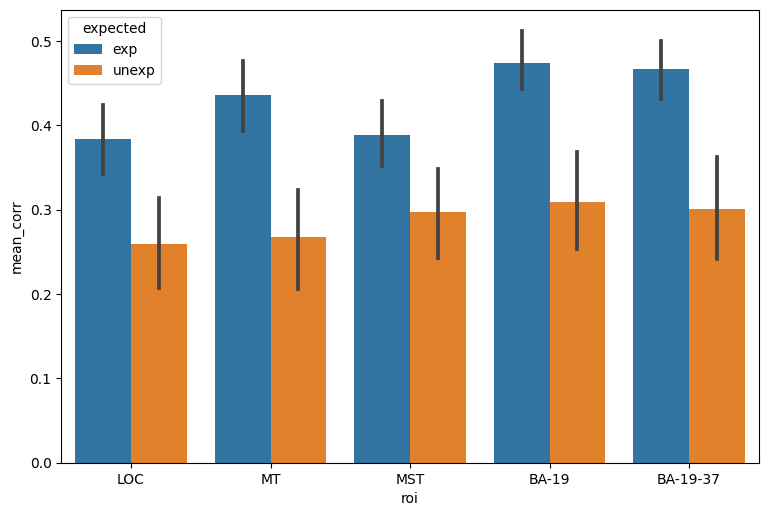

In [13]:
plt.figure(figsize=(9, 6), dpi=100)
sns.barplot(data=df, x='roi', y='mean_corr', hue='expected', ci=68)
plt.show()

In [29]:
LOCmean

0.5317902428139734

In [30]:
MTmean

0.5198596172553984

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


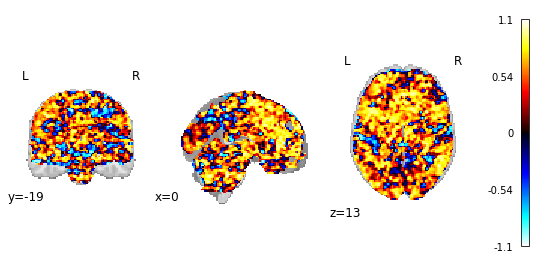

In [15]:
plot_stat_map(thiscorrmap, draw_cross=False)

In [12]:
LOCdata = mask_functional_map(thiscorrmap, thisLOCmask)

/home/predatt/giaald/.conda/envs/giacomo37/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


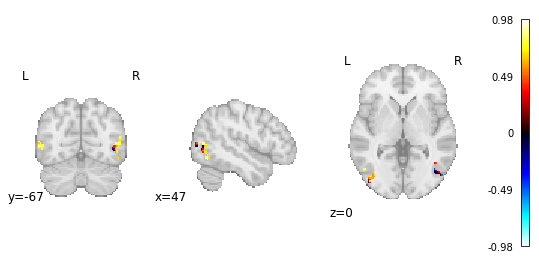

In [14]:
plot_stat_map(LOCdata, draw_cross=False)

In [16]:
corrdata = thiscorrmap.get_fdata()
maskdata = thisLOCmask.get_fdata()

In [20]:
masked=corrdata[maskdata.astype(bool)]

In [21]:
masked.shape

(500,)

In [23]:
np.nanmean(masked)

0.5317902428139734